## Spam Text Messsage Classification

This dataset is downloaded from https://www.kaggle.com/team-ai/spam-text-message-classification and consists of text message with labels ham/spam.
Our objective is to bulid a classifier which can detect whether text message is ham/spam.

### Importing required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold,cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

### Data loading:
Loading data from csv file and performing stemming operation on each text messages. 

In [5]:
#%% Data loading
data=pd.read_csv('SPAM text message 20170820 - Data.csv')
stemmer=PorterStemmer() # Stemming
lemmat=WordNetLemmatizer() # Lemmatization

x=data['Message'] # sms data
y=data['Category'] # target whether spam or ham
y= LabelEncoder().fit_transform(y) # Encoding target variable
mess=[]
for i in range(len(x)):
    review = re.sub('[^a-zA-Z]', ' ', x[i]) # Only words are considered and remaining other is replaced with space.
    review = review.lower() # Coverting sentence into lower case
    review = review.split() # Spliting sentence into words
    # porter stemming
    review = [stemmer.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review =' '.join(review) # Joining stemmed words to produce a sentence
    mess.append(review)

Splitting dataset into train and test dataset

In [6]:
x_train,x_test,y_train,y_test=train_test_split(mess,y,test_size=0.2)

### Bag of words:
Performing bag of words operations for training dataset and later using transform for test dataset. Scaling was also performed on train dataset and same transform is used for test dataset.

In [7]:
#%% converting text data into numbers using bag of words
bow=CountVectorizer(max_features=500)
bow.fit(x_train)
x_tr = bow.transform(x_train).toarray()
x_te = bow.transform(x_test).toarray()

scaler=StandardScaler()
scaler.fit(x_tr)
x_tr=scaler.transform(x_tr)
x_te=scaler.transform(x_te)

### Exploratory data analysis:
EDA is performed on the training dataset using TSNE and PCA. 

No handles with labels found to put in legend.


Total variance captured:  0.022196704130518656


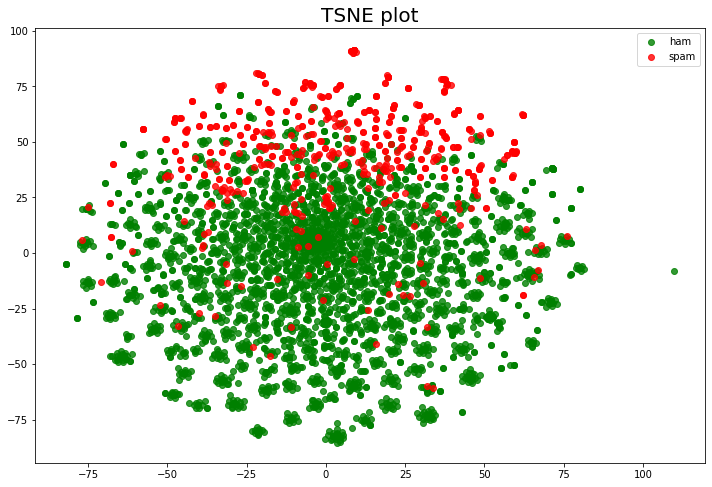

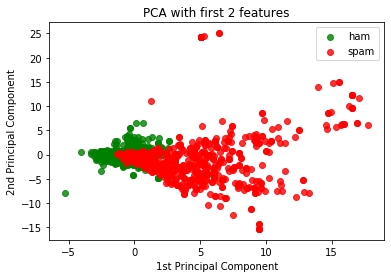

In [8]:
#%% TSNE plot for EDA 
%matplotlib inline
def tsne_plot(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8)
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8) 
    plt.legend(loc='best')
    plt.legend(['ham','spam'])                           
    plt.title('TSNE plot',fontsize=20)

tsne_plot(x_tr,y_train)

def principal_component(x,y,n_components=2):
    n_pca=PCA(n_components=n_components).fit(x)
    pca_norm=n_pca.fit_transform(x)
    plt.figure()
    plt.scatter(pca_norm[np.where(y == 0), 0], pca_norm[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8)
    plt.scatter(pca_norm[np.where(y == 1), 0], pca_norm[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8) 
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.title('PCA with first 2 features')
    plt.legend(['ham','spam'])                
    print('Total variance captured: ',sum(n_pca.explained_variance_ratio_))
    return n_pca,pca_norm

n_pca,red_pca=principal_component(x_tr,y_train,2) # pass dataframe 

From both plot we can see two clusters in just two dimension, this clusters will be more clear in multidimension. So we can proceed with different classifers to classify data into ham or spam.

In [10]:
classifier=[GaussianNB,KNeighborsClassifier,AdaBoostClassifier,
            RandomForestClassifier,XGBClassifier] # Various classifier are tried at same time.
def prediction(clf,x,y,k):
    pred=clf.predict_proba(x)
    pred_1=clf.predict(x)
    print('Accuracy Score',metrics.accuracy_score(y,pred_1))
    cv=KFold(n_splits=k,shuffle=True,random_state=33)
    scores = cross_val_score(clf, x, y, cv=cv)
    print("Average coefficient of determination using 5-foldcrossvalidation:",np.mean(scores))        
    yes_auc = roc_auc_score(y, pred[:,1])
    print('ROC AUC=%.3f' % (yes_auc))
    return pred_1

def best_classifer(x,y,k):
    pred=[]
    for i in range(len(classifier)):        
        print(classifier[i])
        clf=classifier[i]().fit(x,y)
        pred.append(prediction(clf,x,y,5))
    return pred

_=best_classifer(x_tr,y_train,5)

<class 'sklearn.naive_bayes.GaussianNB'>
Accuracy Score 0.6596365268117568
Average coefficient of determination using 5-foldcrossvalidation: 0.6805018294554916
ROC AUC=0.804
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Accuracy Score 0.9439084586044425
Average coefficient of determination using 5-foldcrossvalidation: 0.9252867489040882
ROC AUC=0.992
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Accuracy Score 0.9818263405878394
Average coefficient of determination using 5-foldcrossvalidation: 0.9732990090239717
ROC AUC=0.991
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy Score 0.9982050706753421
Average coefficient of determination using 5-foldcrossvalidation: 0.9773371482639046
ROC AUC=0.999
<class 'xgboost.sklearn.XGBClassifier'>
Accuracy Score 0.9759928202827014
Average coefficient of determination using 5-foldcrossvalidation: 0.9685874691106381
ROC AUC=0.981


Among this we can select any classifer. Here XGBoost classifier is chosen, further hyperparameters are tuned to get better accuracy.

In [8]:
param_dist = {'n_estimator':[100,1000,2000,3000],'learning_rate':[0.01,0.1,0.2,0.3]}
g_search = GridSearchCV(XGBClassifier(),param_grid = param_dist,n_jobs=-1)
g_search.fit(x_tr,y_train)
print(g_search.best_score_)
print(g_search.best_params_)

0.977563125022019
{'learning_rate': 0.3, 'n_estimator': 100}


In [11]:
# Best paramater selected
clf=XGBClassifier(n_estimator=100,learning_rate=0.3).fit(x_tr,y_train)
train_pred=prediction(clf,x_tr,y_train,5)
test_pred=prediction(clf,x_te,y_test,5)

Accuracy Score 0.9860892977339017
Average coefficient of determination using 5-foldcrossvalidation: 0.9793570986396098
ROC AUC=0.990
Accuracy Score 0.9748878923766816
Average coefficient of determination using 5-foldcrossvalidation: 0.9542600896860988
ROC AUC=0.977


### Conclusion:
So, finally XGBoost classifer has given 98.6% accuracy in training dataset and 97.5% accuracy on test dataset. This classifier can be used to detect whether a text message is ham or spam.